# CNN for classification

Problem

The calorimeter has a multiple showers where the energy is distributed through multiple blocks. The shower centers can be anywhere in the calorimeter ( –1000 < x,y < +1000 ) and will never be outside of that. Energy from the shower that falls outside of the calorimeter however, is lost. 

In the example, there are 6 showers. 

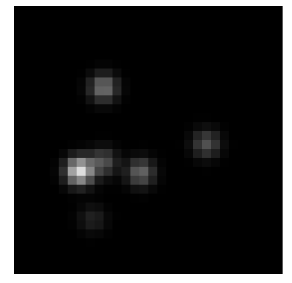

The showers here are all “clean” with no noise or backgrounds. 

The data comes as PNG files (8-bit greyscale) for each of the events that are stored in the relevant directory such as "train_images". For this set, there is an CSV file named "train_images.csv". The first column is just the PNG file name and the last column is the number of showers. 

The solution to this problem will consist of a single CSV file with a single column containing the number of showers in the event for the events in the judge.csv or judge_images.csv file. The order of the events should correspond to the same order as in the input file.

Our input is represented as a set of images, that's why CNN was chosen as a model. And we need to get the predictions for the number of showers (from 0 to 10), so we face with the classification task.

Firstly let's import all necessary python libraries

In [72]:
import os
from os import listdir
from os.path import isfile, join
import glob
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt

Get input from csv-file and create Pandas DataFrames with train, test and judge data

In [92]:
source = "https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem3/"

# train dataset
df_train = pd.read_csv(
    os.path.join(source,"train_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_train.columns[0]: 'filename', df_train.columns[1]: 'showers'}
df_train = df_train.rename(columns=mapping)

df_train['filename'] = df_train['filename'].str.replace(r'^t\w*([^.])', '',regex=True)
df_train['filename'] = df_train['filename'].str.replace(r'.png', '',regex=True)+'.png'
df_train['showers'] = df_train['showers'] .astype(str) #str type is requirement for categorical class mode

# test dataset
df_test = pd.read_csv(
    os.path.join(source,"test_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_test.columns[0]: 'filename', df_test.columns[1]: 'showers'}
df_test = df_test.rename(columns=mapping)

df_test['filename'] = df_test['filename'].str.replace(r'^t\w*([^.])', '',regex=True)
df_test['filename'] = df_test['filename'].str.replace(r'.png', '',regex=True)+'.png'
df_test['showers'] = df_test['showers'] .astype(str) #str type is requirement for categorical class mode

# judge dataset
df_judge = pd.read_csv(
    os.path.join(source,"judge_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_judge.columns[0]: 'filename'}
df_judge = df_judge.rename(columns=mapping)

df_judge['filename'] = df_judge['filename'].str.replace(r'^j\w*([^.])', '',regex=True)
df_judge['filename'] = df_judge['filename'].str.replace(r'.png', '',regex=True)+'.png'

df_judge
print(f"Training size: {len(df_train)}")
print(f"Test size: {len(df_test)}")
print(f"Judge size: {len(df_judge)}")


Training size: 10000
Test size: 2000
Judge size: 2000


Let's build a data generator. We will not divide the train dataset to the train and validation datasets, we'll just use test data for validation purpose

In [81]:
datagen=ImageDataGenerator()

The function flow_from_dataframe loads the labels from a Pandas dataframe connected to our train_images.csv file. 

We have to specify paths to the directories which contains all the images, because our x_col doesn't contain absolute_paths pointing to each image files instead of just filenames.

Parameter x_col points to the name of the column which contains the filenames of the images, y_col — points to the name of the column which contains the label.

We have to set class_mode equals to “categorical”, because we have the data in the column as categorical values (str datatype).

Batch_size will be 32 for the training and validation datasets and 1 for the test dataset.

Shuffle is set to True for train and validation generators and False for test generator, because we need to yield the images in “order”, to predict the outputs and match them with their unique filenames.

In [104]:
path_train = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem3/train_images'
path_test = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem3/test_images'
path_judge = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem3/judge_images'

train_generator=datagen.flow_from_dataframe(
                dataframe=df_train,
                directory=path_train,
                x_col="filename",
                y_col="showers",
                batch_size=32,
                seed=42,
                #shuffle=True,
                class_mode="categorical",
                target_size=(30,30),
                color_mode='grayscale')

valid_generator=datagen.flow_from_dataframe(
                dataframe=df_test,
                directory=path_test,
                x_col="filename",
                y_col="showers",
                batch_size=32,
                seed=42,
                #shuffle=True,
                class_mode="categorical",
                target_size=(30,30),
                color_mode='grayscale')

test_datagen=ImageDataGenerator()

test_generator=test_datagen.flow_from_dataframe(
                dataframe=df_judge,
                directory=path_judge,
                x_col="filename",
                y_col="showers",
                batch_size=1,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(30,30),
                color_mode='grayscale')

Found 10000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames.


Now let's build the model.

In [105]:
class_count = len(train_generator.class_indices)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(30,30,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])


Let's fit the model.

In [106]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)


Epoch 1/10
312/312 [==============================] - 15s 47ms/step - loss: 1.9042 - accuracy: 0.3769 - val_loss: 1.7550 - val_accuracy: 0.4123
Epoch 2/10
312/312 [==============================] - 14s 46ms/step - loss: 1.3377 - accuracy: 0.5336 - val_loss: 1.2184 - val_accuracy: 0.4009
Epoch 3/10
312/312 [==============================] - 14s 46ms/step - loss: 0.9971 - accuracy: 0.6012 - val_loss: 1.5356 - val_accuracy: 0.4284
Epoch 4/10
312/312 [==============================] - 14s 46ms/step - loss: 0.8847 - accuracy: 0.6373 - val_loss: 1.0457 - val_accuracy: 0.4578
Epoch 5/10
312/312 [==============================] - 15s 47ms/step - loss: 0.8046 - accuracy: 0.6753 - val_loss: 1.2649 - val_accuracy: 0.4776
Epoch 6/10
312/312 [==============================] - 14s 46ms/step - loss: 0.7446 - accuracy: 0.7026 - val_loss: 0.8458 - val_accuracy: 0.4751
Epoch 7/10
312/312 [==============================] - 15s 47ms/step - loss: 0.6965 - accuracy: 0.7243 - val_loss: 1.1709 - val_accuracy:

For clarity we can build the plot

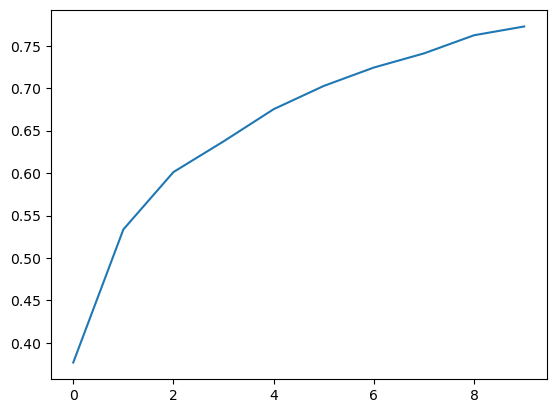

In [107]:
plt.plot(history.history['accuracy'])
plt.show()

Evaluate the model

In [108]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)

[1.2288718223571777, 0.3842277526855469]

Let's predict the output for the judge dataset. We need to reset the test_generator before whenever you call the predict_generator. This is important, if we don't want to get outputs in a weird order.

In [116]:
test_generator.reset()
pred=model.predict_generator(test_generator,
                    steps=STEP_SIZE_TEST,
                    verbose=1)

2000/2000 [==============================] - 3s 1ms/step


Now we have to map the predicted labels with their unique ids such as filenames to find out what you predicted for which image.

In [111]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
len(predictions)

2000

Finally, save the results to a CSV file.

In [112]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

,Filename,Predictions
0,event000000.png,1
1,event000001.png,2
2,event000002.png,2
3,event000003.png,3
4,event000004.png,2
...,...,...
1995,event001995.png,1
1996,event001996.png,2
1997,event001997.png,2
1998,event001998.png,2


We only need a column with the number of showers 

In [115]:
output_judge = results["Predictions"]
path = "C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem3"
output_judge.to_csv(os.path.join(path,"output_judge.csv"),index=False,header=False)